<a href="https://colab.research.google.com/github/i-SanMartin/FastAI/blob/main/06_Multicat/BearClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 18.7 MB/s 
     |████████████████████████████████| 46 kB 4.6 MB/s 
     |████████████████████████████████| 188 kB 51.0 MB/s 
     |████████████████████████████████| 1.2 MB 54.8 MB/s 
     |████████████████████████████████| 53 kB 2.6 MB/s 
     |████████████████████████████████| 51 kB 323 kB/s 
Mounted at /content/gdrive


In [2]:
import shutil
from fastbook import *
from fastai.vision.widgets import *

In [3]:
!pip install -q jmd_imagescraper
from pathlib import Path
from jmd_imagescraper.core import *

In [4]:
pet_types = "grizzly bear", "black bear", "teddy bear"
path = Path().cwd()/"pets"

In [5]:
if path.exists():
    shutil.rmtree(path)

if not path.exists():
    path.mkdir()
    for o in pet_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = duckduckgo_search(path, o, o, max_results=100)

Duckduckgo search: grizzly bear


Duckduckgo search: black bear


Duckduckgo search: teddy bear


In [6]:
fns = get_image_files(path)
fns

(#300) [Path('/content/pets/grizzly bear/007_fa3085d4.jpg'),Path('/content/pets/grizzly bear/060_e801ef4b.jpg'),Path('/content/pets/grizzly bear/100_74aeb34c.jpg'),Path('/content/pets/grizzly bear/040_1f022e4e.jpg'),Path('/content/pets/grizzly bear/012_0618411a.jpg'),Path('/content/pets/grizzly bear/086_1d3692e3.jpg'),Path('/content/pets/grizzly bear/058_fc5a9d68.jpg'),Path('/content/pets/grizzly bear/001_7ba34c6a.jpg'),Path('/content/pets/grizzly bear/021_1dc49a78.jpg'),Path('/content/pets/grizzly bear/038_440d4087.jpg')...]

In [7]:
failed = verify_images(fns)
failed

(#0) []

##Single Label

In [105]:
pets = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [106]:
pets = pets.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = pets.dataloaders(path)

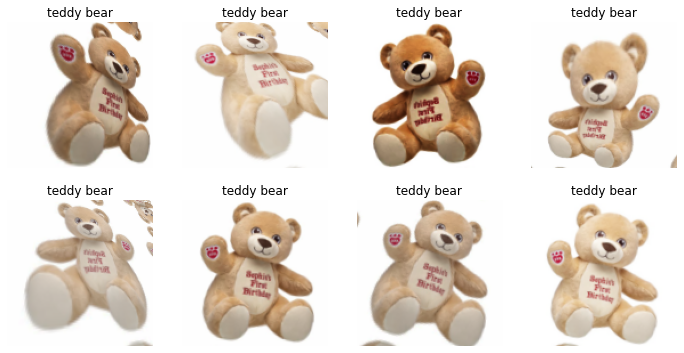

In [42]:
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [107]:
pets = pets.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = pets.dataloaders(path)

In [108]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)

In [109]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.698001,0.322080,0.133333,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.564435,0.141410,0.016667,00:02
1,0.469659,0.090593,0.033333,00:02
2,0.397108,0.105178,0.050000,00:02
3,0.332363,0.107490,0.050000,00:02


##MultiLabel

In [136]:
def get_y(r): 
  if parent_label(r) == "black bear":
    return ["black bear"]
  elif parent_label(r) == "grizzly bear":
    return ["grizzly bear"]
  elif parent_label(r) == "teddy bear":
    return ["teddy bear"]

In [137]:
print(get_y(Path(/content/pets/black bear/001_3a2bb2f1.jpg)))

['black bear']


In [138]:
pets = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=get_y,
    item_tfms=Resize(128))

In [139]:
pets = pets.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = pets.dataloaders(path)
dls.train_ds[0]

(PILImage mode=RGB size=474x474, TensorMultiCategory([0., 0., 1.]))

In [140]:
dls.train.vocab[0]

'black bear'

In [148]:
learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.8))

In [149]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.857461,0.449241,0.900000,00:02


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.425459,0.265066,0.950000,00:03
1,0.358866,0.181933,0.966667,00:03
2,0.294094,0.124592,0.961111,00:03
3,0.250674,0.101246,0.977778,00:03
